This notebook should set up the basic (preliminary) generative model for our data, and use it to fit teh parameters $\Delta m^2$ and $sin^2(2\theta)$ from the neutrino oscillation formula

In [6]:
# Import statements - only things we're actively using!
import numpy as np
import pandas as pd
import pymc3 as pm

Useful constants
values of ss2t, dms to try:
-  LSND best fit (ss2t = 0.003, dms = 1.2)
-  Giunti best fit (ss2t = 0.0011, dms = 1.7)
-  Machado best fit (ss2t = 0.0038, dms = 1.3)

In [7]:
# Adapted from week 07 notebook

def oscillation_model(fake_data):
    uncertainty = 1.0 
    #This is chosen arbitrarily - we'll re-evaluate to get a better value when we work on making our model reflective of reality

    # reshape data so it behaves when pymc3 tests multiple parameter values at once
    L = fake_data['L'].values[:, np.newaxis]
    E = fake_data['E'].values[:, np.newaxis]
    num_neutrinos = fake_data['N_numu']
    num_nue = fake_data['N_nue']

    # The following two lines set up the model, which is a Python object.  
    # "with peaks_model" is called a context manager: It provides a convenient way to set up the object. 
    osc_model = pm.Model()
    with osc_model:
    
        # Priors for unknown model parameters
        ss2t = pm.Uniform('sin^2_2theta', 0, 1)
        dms = pm.Uniform('delta_m^2', 0, 2)  
        
        # Expected value from theory 
        P = pm.Deterministic('prediction', ss2t*(np.sin(dms*(1.27*L)/E))**2)
        
        # Likelihood of observations
        # Oscillation from numu to nue is like a weighted coin toss, so we use the binomial distribution
        measurements = pm.Binomial('nue_Flux', n=num_neutrinos, p=P, observed=num_nue)
        
    return osc_model

def fit_model(data, initial_guess = {'sin^2_2theta':0.1, 'delta_m^2':1}):
    
    uncertainty = 0.3
    osc_model = oscillation_model(data)
    best_fit, scipy_output = pm.find_MAP(model=osc_model, start = initial_guess, return_raw=True)    
    covariance_matrix = np.flip(scipy_output.hess_inv.todense()/uncertainty)
    
    return best_fit, covariance_matrix

def chisq(fake_data, prediction):
    '''
    Finds chi-squared for a given model
    
    Parameters
    --------
    prediction: numpy array
        the prediction from best-fit of for a given model 
        (the best fit means this gives the minimum chi squared)
    x_vals: numpy array
        the y values for our data
    
    Returns
    --------
    float:
        the chi-squared
    '''   
    uncertainty = 0.3
    observed = fake_data['N_nue']
    res_squared = np.power(prediction-observed, 2)
    chisq = np.sum(res_squared/uncertainty**2)
    
    return chisq
                         


In [17]:
def print_fit_vals(bf, cov):
    
    '''
    literally just prints the best fit values and their uncertainties nicely
    
    Inputs:
    bf: best fit from the model
    cov: covariance matrix from the model
    '''
    points = len(cov[0])
    values = np.zeros(points)
    rows = np.full(points, '00000000000000')
    uncertainty = np.zeros(points)
    
    values[0] = bf['sin^2_2theta']
    rows[0] = 'sin^2_2theta'
    uncertainty[0] = np.sqrt(cov[0][0])

    values[1] = bf['delta_m^2']
    rows[1] = 'delta_m^2'
    uncertainty[1] = np.sqrt(cov[1][1])
    
    vals = { 'value': values}
    fit_values = pd.DataFrame(vals, index = rows)
    fit_values['uncertainty'] = uncertainty

    return fit_values

The cells below are for testing the code in this notebook independent of the rest of the package

In [4]:
#Create some very fake data for testing purposes
test_data = pd.DataFrame({ 'L': [450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 467, 468, 469, 470],
                          'E': [1, 1, 2, 2, 1.5, 1.5, 0.8, 0.8, 0.9, 0.9, 1, 1, 2, 2, 1.5, 1.5, 0.8, 0.8, 0.9, 0.9],
                          'N_numu': 20, 'N_nue': 1}) #N_numu and N_nue don't need to be integers


In [9]:
oscillation_model(test_data)

In [10]:
best_fit, cov = fit_model(test_data)

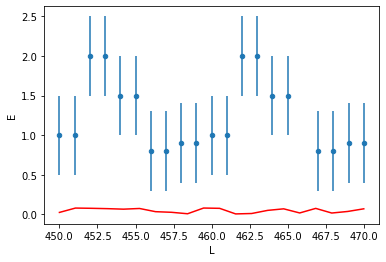

In [15]:
test_data.plot(x='L', y='E', kind='scatter', yerr=0.5)
x = np.linspace(min(test_data['L']), max(test_data['L']), 20)

import matplotlib.pyplot as plt
plt.plot(x, best_fit['prediction'], '-k', color='red')

In [18]:
print_fit_vals(best_fit, cov)

,value,uncertainty
sin^2_2theta,0.080801,0.821210
delta_m^2,0.836597,0.053899
